In [2]:
import numpy as np
from numpy import linalg as LA
from river import anomaly

In [3]:
def read_data(path: str, delimiter: str, step_size: int):
    times = []
    nodes = []
    edges = []

    with open(path, "r") as graph_file:
        lines = graph_file.readlines()

    for line in lines:
        tokens = line.strip().split(delimiter)
        tokens = [int(x) for x in tokens]
        edges.append(tokens)
        times.append(tokens[0])
        nodes.append(tokens[1])
        nodes.append(tokens[2])

    edges.sort(key=lambda a: a[0])
    times.sort()
    nodes.sort()

    initial_time = times[0]
    initial_node = nodes[0]

    for i in range(0, len(edges)-1):
        edges[i][0] -= initial_time
        edges[i][1] -= initial_node
        edges[i][2] -= initial_node

    n = nodes[-1] - initial_node + 1
    m = len(edges)

    return (edges, n, m)

In [4]:
edges, n, m = read_data("KDD19-AnomRank-master/darpa.txt", ' ', 60)

In [56]:
class Node:
    """Data structure to store a node and its (weighted) out-edges.
    
    Parameters
    ----------
    out_node
        list of node names.
    out_weight
        list of edge weight.

    """
    def __init__(self):
        self.total_w = 0
        self.out_degree = 0
        self.out_node = []
        self.out_weight = []
    
    def __len__(self) -> int:
        """
        Returns the number of nodes receiving a link from current node.
        Equilavent to out degree without wight.
        """
        return self.out_degree
    
    def __str__(self) -> str:
         return "Out-degree: " + str(len(self.out_node)) + "\nOut-weight sum:" + str(self.total_w)

class AnomRank(anomaly.AnomalyDetector):
    """AnomRank Anomaly detector .
    Online algorithm to detect two types of anolamies in a graph: 
    sudden weight change in edges and sudden structural changes.
    This approach is based on tracking the derivatives of adapted PageRank scores for each node. 
    
    Parameters
    ----------
    n
        Number of nodes.
    c
        The damping factor for PageRank.
    E
        Epsilon, tolerence to convergence when computing PageRank. 
        Correspond to the maximal value of the changes in PageRank scores in one iteration 
        of the algorithm to consider that PageRank has converged.
        
    Examples
    --------
    score_list = []
    time_step = 60
    current_time = 0
    batch_edges = []

    for edge in tqdm(edges):
        if edge[0] >= current_time + time_step:
            model.learn_one(batch_edges)
            score = model.score_one()
            score_list.append(score)
            current_time += time_step
            batch_edges = [[edge[1], edge[2]]]
        else:
            batch_edges.append([edge[1], edge[2]])

    
    """
    def __init__(self, n: int, c: int = 0.50, E: float = 0.001):
        # hyperparameters
        self.c = c
        self.n = n
        self.E = E
        # variables initialisation
        self.A = [Node() for empty_node in range(n)]
        self.m = 0
        self.t = 0
        self.bs = np.array([1/self.n] * self.n)
        self.mean = np.zeros(self.n)
        self.var = np.zeros(self.n)
        self.scoreS_new = None
        self.scoreS_old = None
        self.scoreS_second_old = None
        self.scoreW_new = None 
        self.scoreW_old = None
        self.scoreW_second_old = None
        self.anomrankS_list = []
        self.anomrankW_list = []
        
    def add_edge(self, src: int, trg: int, w: int):
        """Add a directed weighted edge to the graph.
        
        Parameters
        ----------
        src
            Source node of the edge.
        trg
            Target node of the edge.
        w
            Weight of the edge.
            
        Returns
        -------
        None
        """
        in_matrix = False
        for index in range(len(self.A[src].out_node)):
            if(self.A[src].out_node[index] == trg):
                self.A[src].out_weight[index] += w
                self.A[src].total_w += w
                in_matrix = True
                break

        if not in_matrix:
            self.A[src].out_node.append(trg)
            self.A[src].out_weight.append(w)
            self.A[src].total_w += w
            self.A[src].out_degree += 1
        self.m += 1

    def pagerank_s(self):
        """Compute non-weighted PageRank score for each node of the graph.
        
        Parameters
        ----------
        None
            
        Returns
        -------
        Vector with the PageRank score of each node.
        """
        b = self.c * self.bs
        pr_prev = b
        delta_score = 100
        nb_edges =  [node.out_degree for node in self.A] #to check
        
        while delta_score > self.E:
            pr = np.zeros(self.n)
            delta = (1-self.c)* np.divide(pr_prev, nb_edges, out=np.zeros_like(pr_prev), where=nb_edges!=0)
            
            for scr_index in range(len(self.A)):
                for trg_index in range(len(self.A[scr_index])):
                    trg_name = self.A[scr_index].out_node[trg_index]
                    pr[trg_name] += delta[scr_index]
            
            delta_score = LA.norm(pr, 1)
            b += pr
            pr_prev = pr
        
        score_sum = np.sum(b)
        b = np.divide(b, score_sum, out=np.zeros_like(b), where=score_sum!=0)
        return b
    
    def pagerank_w(self):
        """Compute Weighted PageRank score for each node of the graph.
        
        Parameters
        ----------
        None
            
        Returns
        -------
        Vector with the Weighted PageRank score of each node.
        """
        weighted_degree = [node.total_w for node in self.A]
        b = [self.c * weight / self.m for weight in weighted_degree]
        pr_prev = b
        delta_score = 100
        
        while delta_score > self.E:
            pr = np.zeros(self.n)
            delta = (1-self.c)* np.divide(pr_prev, weighted_degree, out=np.zeros_like(pr_prev), where=weighted_degree!=0)
            for scr_index in range(len(self.A)):
                for trg_index in range(len(self.A[scr_index])):
                    trg_name = self.A[scr_index].out_node[trg_index]
                    pr[trg_name] += delta[scr_index] * self.A[scr_index].out_weight[trg_index]
            
            delta_score = LA.norm(pr, 1)
            b += pr
            pr_prev = pr
            
        score_sum = np.sum(b)
        b = np.divide(b, score_sum, out=np.zeros_like(b), where=score_sum!=0)
        return b
    
    def learn_one(self, x: list) -> "AnomRank":
        """Update the model with the input edges and pagerank scores.
        
        Parameters
        ----------
        x
            list of edges containing source node and target node.
            
        Returns
        -------
        self 
            The model
        """
        for edge in x:
            self.add_edge(edge[0], edge[1], 1)
        self.t += 1
        # update scoreS
        self.scoreS_second_old = self.scoreS_old
        self.scoreS_old = self.scoreS_new
        self.scoreS_new = self.pagerank_s() 
        # update scoreW
        self.scoreW_second_old = self.scoreW_old
        self.scoreW_old = self.scoreW_new
        self.scoreW_new = self.pagerank_w()
        return self

    def normalize_score(self, scores):
        self.mean = self.t / (self.t + 1) * self.mean + 1 / (self.t + 1) * np.array(scores)
        self.var = self.t / (self.t + 1) * self.var + 1 / (self.t + 1) * np.array(scores)**2
        standard_dev = np.sqrt(self.var - self.mean**2)
        scores -= self.mean
        scores = np.divide(scores, standard_dev, out=np.zeros_like(scores), where=standard_dev!=0) 
        return scores

    def score_one(self) -> float:
        """Return an outlier score.
        A high score is indicative of an anomaly. A low score corresponds a normal observation.

        Parameters
        ----------
        None
            
        Returns
        -------
        An anomaly score. A high score is indicative of an anomaly. A low score corresponds a
        normal observation.
        """
        
        if not self.scoreW_second_old is None:
            # compute anomrankS
            scoreS_1d = self.scoreS_new - self.scoreS_old #1st deriative
            scoreS_1d_norm = self.normalize_score(scoreS_1d)
            scoreS_2d = self.scoreS_new - 2*self.scoreS_old + self.scoreS_second_old #2nd deriative
            scoreS_2d_norm = self.normalize_score(scoreS_2d)
            anomrankS = np.concatenate((scoreS_1d, scoreS_2d), axis=0)
            anomrankS_score = LA.norm(anomrankS, 1)
            self.anomrankS_list.append(anomrankS_score)
            # compute anomrankW
            scoreW_1d = self.scoreW_new - self.scoreW_old #1st deriative
            scoreW_1d_norm = self.normalize_score(scoreW_1d)
            scoreW_2d = self.scoreW_new - 2*self.scoreW_old + self.scoreW_second_old #2nd deriative
            scoreW_2d_norm = self.normalize_score(scoreW_2d)
            anomrankW = np.concatenate((scoreW_1d, scoreW_2d), axis=0)
            anomrankW_score = LA.norm(anomrankW, 1)
            self.anomrankW_list.append(anomrankW_score)
            # compute anomaly score
            anomaly_score = max(anomrankS_score, anomrankW_score)
            return anomaly_score
        else:
            print("Can't provide a real score, missing data points.")
            return 0.0


In [57]:
model = AnomRank(n=n)

In [58]:
from tqdm import tqdm
from math import floor

t = []
score_list = []
time_step = 60
current_time = 0
batch_edges = []

for edge in tqdm(edges):
    if edge[0] >= current_time + time_step:
        model.learn_one(batch_edges)
        score = model.score_one()
        score_list.append(score)
        current_time += time_step
        t.append(current_time)
        batch_edges = [[edge[1], edge[2]]]
    else:
        batch_edges.append([edge[1], edge[2]])


  0%|                                                                                                                                                                                                              | 0/4554344 [00:00<?, ?it/s]/tmp/ipykernel_5652/692220352.py:134: RuntimeWarning: divide by zero encountered in true_divide
  delta = (1-self.c)* np.divide(pr_prev, nb_edges, out=np.zeros_like(pr_prev), where=nb_edges!=0)
/tmp/ipykernel_5652/692220352.py:167: RuntimeWarning: invalid value encountered in true_divide
  delta = (1-self.c)* np.divide(pr_prev, weighted_degree, out=np.zeros_like(pr_prev), where=weighted_degree!=0)
/tmp/ipykernel_5652/692220352.py:167: RuntimeWarning: divide by zero encountered in true_divide
  delta = (1-self.c)* np.divide(pr_prev, weighted_degree, out=np.zeros_like(pr_prev), where=weighted_degree!=0)
  0%|▏                                                                                                                                                  

Can't provide a real score, missing data points.
Can't provide a real score, missing data points.


  1%|██▊                                                                                                                                                                                             | 67519/4554344 [00:03<07:42, 9703.82it/s]/tmp/ipykernel_5652/692220352.py:134: RuntimeWarning: invalid value encountered in true_divide
  delta = (1-self.c)* np.divide(pr_prev, nb_edges, out=np.zeros_like(pr_prev), where=nb_edges!=0)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4554344/4554344 [11:52<00:00, 6395.64it/s]


In [59]:
model

AnomRank (
  n=25525
  c=0.5
  E=0.001
)

In [61]:
from tqdm import tqdm
import matplotlib.pyplot as plt

time_step = 60
current_time = 0
batch_attks = []
attk_list = []
for edge in tqdm(edges):
    if edge[0] >= current_time + time_step:
        current_time += time_step
        attk_list.append(np.array(batch_attks).sum() > 50)
        batch_attks = [edge[3]]
    else:
        batch_edges.append([edge[1], edge[2]])
        batch_attks.append(edge[3])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4554344/4554344 [00:04<00:00, 940158.74it/s]


Text(0, 0.5, 'anomaly score')

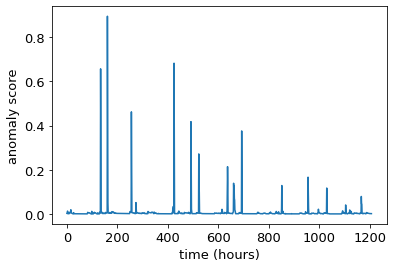

In [62]:
plt.rc('font', size=13)
init_time = 255
plt.plot([minuts/60 - init_time for minuts in t[init_time:]], score_list[init_time:])
plt.xlabel('time (hours)')
plt.ylabel('anomaly score')

In [63]:
selected_attacks = attk_list[init_time:]

Text(0, 0.5, 'log(anomaly score)')

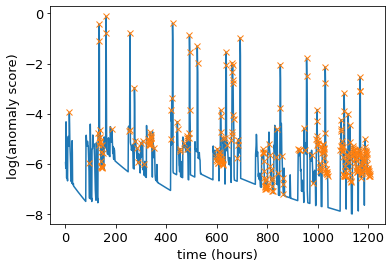

In [64]:
attaks_position = []
for i in range(len(attk_list)):
    if attk_list[i]:
        attaks_position.append(score_list[i])
    else:
        attaks_position.append(np.nan)
init_time = 255
plt.plot([minuts/60 - init_time for minuts in t[init_time:]], [np.log(scoring) for scoring in score_list[init_time:]])
plt.plot([minuts/60 - init_time for minuts in t[init_time:]], [np.log(atk) for atk in attaks_position[init_time:]], 'x')
plt.xlabel('time (hours)')
plt.ylabel('log(anomaly score)')

In [69]:
selected_scores = []
offset = 2
eval_scores = score_list

for i in range(init_time - offset, len(eval_scores) - offset):
    selected_scores.append((eval_scores[i], i-init_time))

In [70]:
selected_scores.sort(key=lambda y: y[0], reverse=True)

In [72]:
tops = [50, 100, 150, 250, 500]
for top in tops:
    tp = 0
    fp = 0
    for high in selected_scores[:top]:
        if selected_attacks[high[1]]:
            tp += 1
        else:
            fp += 1
    print("precision @" + str(top) + ": ", tp/top)

precision @50:  0.8
precision @100:  0.61
precision @150:  0.5533333333333333
precision @250:  0.44
precision @500:  0.39
